In [57]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
train_path = 'test-data/train'
valid_path = 'test-data/valid'
test_path = 'test-data/test'

In [59]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['cats', 'dogs'], batch_size=4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),classes=['cats', 'dogs'], batch_size=10)

Found 93 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 14 images belonging to 2 classes.


In [60]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [61]:
imgs, labels = next(train_batches)

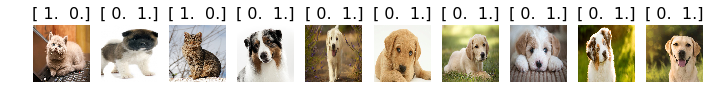

In [62]:
plots(imgs, titles=labels)

## Build Fine-tuned VGG16 model

In [63]:
vgg16_model = keras.applications.vgg16.VGG16()

In [36]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [64]:
#create our own model to finetune
model = Sequential()
for layer in vgg16_model.layers:
    model.add(layer)

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [65]:
#remove the last layer that is used for prediction
model.layers.pop()

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [66]:
#keep the weights etc
for layer in model.layers:
    layer.trainable = False

In [67]:
#just add our data for classification
model.add(Dense(2, activation='softmax'))

In [68]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Train the VGG16 model

In [69]:
# Use Adam optimizer to optimize weights
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [70]:
model.fit_generator(train_batches, steps_per_epoch=4, 
                    validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Epoch 1/5
70s - loss: 0.6883 - acc: 0.5750 - val_loss: 0.6834 - val_acc: 0.8125
Epoch 2/5
72s - loss: 0.6822 - acc: 0.7750 - val_loss: 0.6784 - val_acc: 0.8125
Epoch 3/5
60s - loss: 0.6767 - acc: 0.7970 - val_loss: 0.6756 - val_acc: 0.9375
Epoch 4/5
69s - loss: 0.6761 - acc: 0.8500 - val_loss: 0.6702 - val_acc: 0.9375
Epoch 5/5
59s - loss: 0.6753 - acc: 0.8958 - val_loss: 0.6682 - val_acc: 0.9375


## Predict using fine-tuned VGG16 model

Found 14 images belonging to 2 classes.


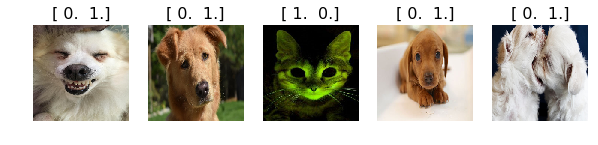

In [90]:
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),classes=['cats', 'dogs'], batch_size=5)
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [91]:
test_labels = test_labels[:,0]
test_labels

array([ 0.,  0.,  1.,  0.,  0.], dtype=float32)

In [93]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [94]:
predictions

array([[ 0.49100536,  0.50899464],
       [ 0.51516062,  0.48483938],
       [ 0.49478844,  0.50521159],
       [ 0.50832528,  0.49167481],
       [ 0.4881838 ,  0.5118162 ]], dtype=float32)

In [95]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

In [96]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2 2]
 [1 0]]


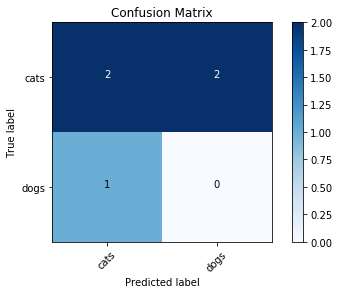

In [97]:
cm_plot_labels = ['cats','dogs']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
model.predict()